# Lecture 2
_____________


## _Load data and plot_

Define conversion factor from cfs to thousand acre-feet per day

In [1]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

We'll use the `loadtxt` function from numpy to read the CSV.

The delimiter is a comma. Other options might be tab `\t` or space `\s`.

We want to skip the header row and the first (0th) column because they contain strings

In general it's better to use the `pandas` library to load CSVs, which we'll see later

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

data = np.loadtxt('data/SHA.csv', delimiter=',',
                 skiprows=1, usecols=[1,2,3,4])

In [3]:
inflow = data[:,0] * cfs_to_tafd # TAF/d
outflow = data[:,1] * cfs_to_tafd # TAF/d
storage = data[:,2] / 1000 # AF to TAF

#### First plot: time series of storage

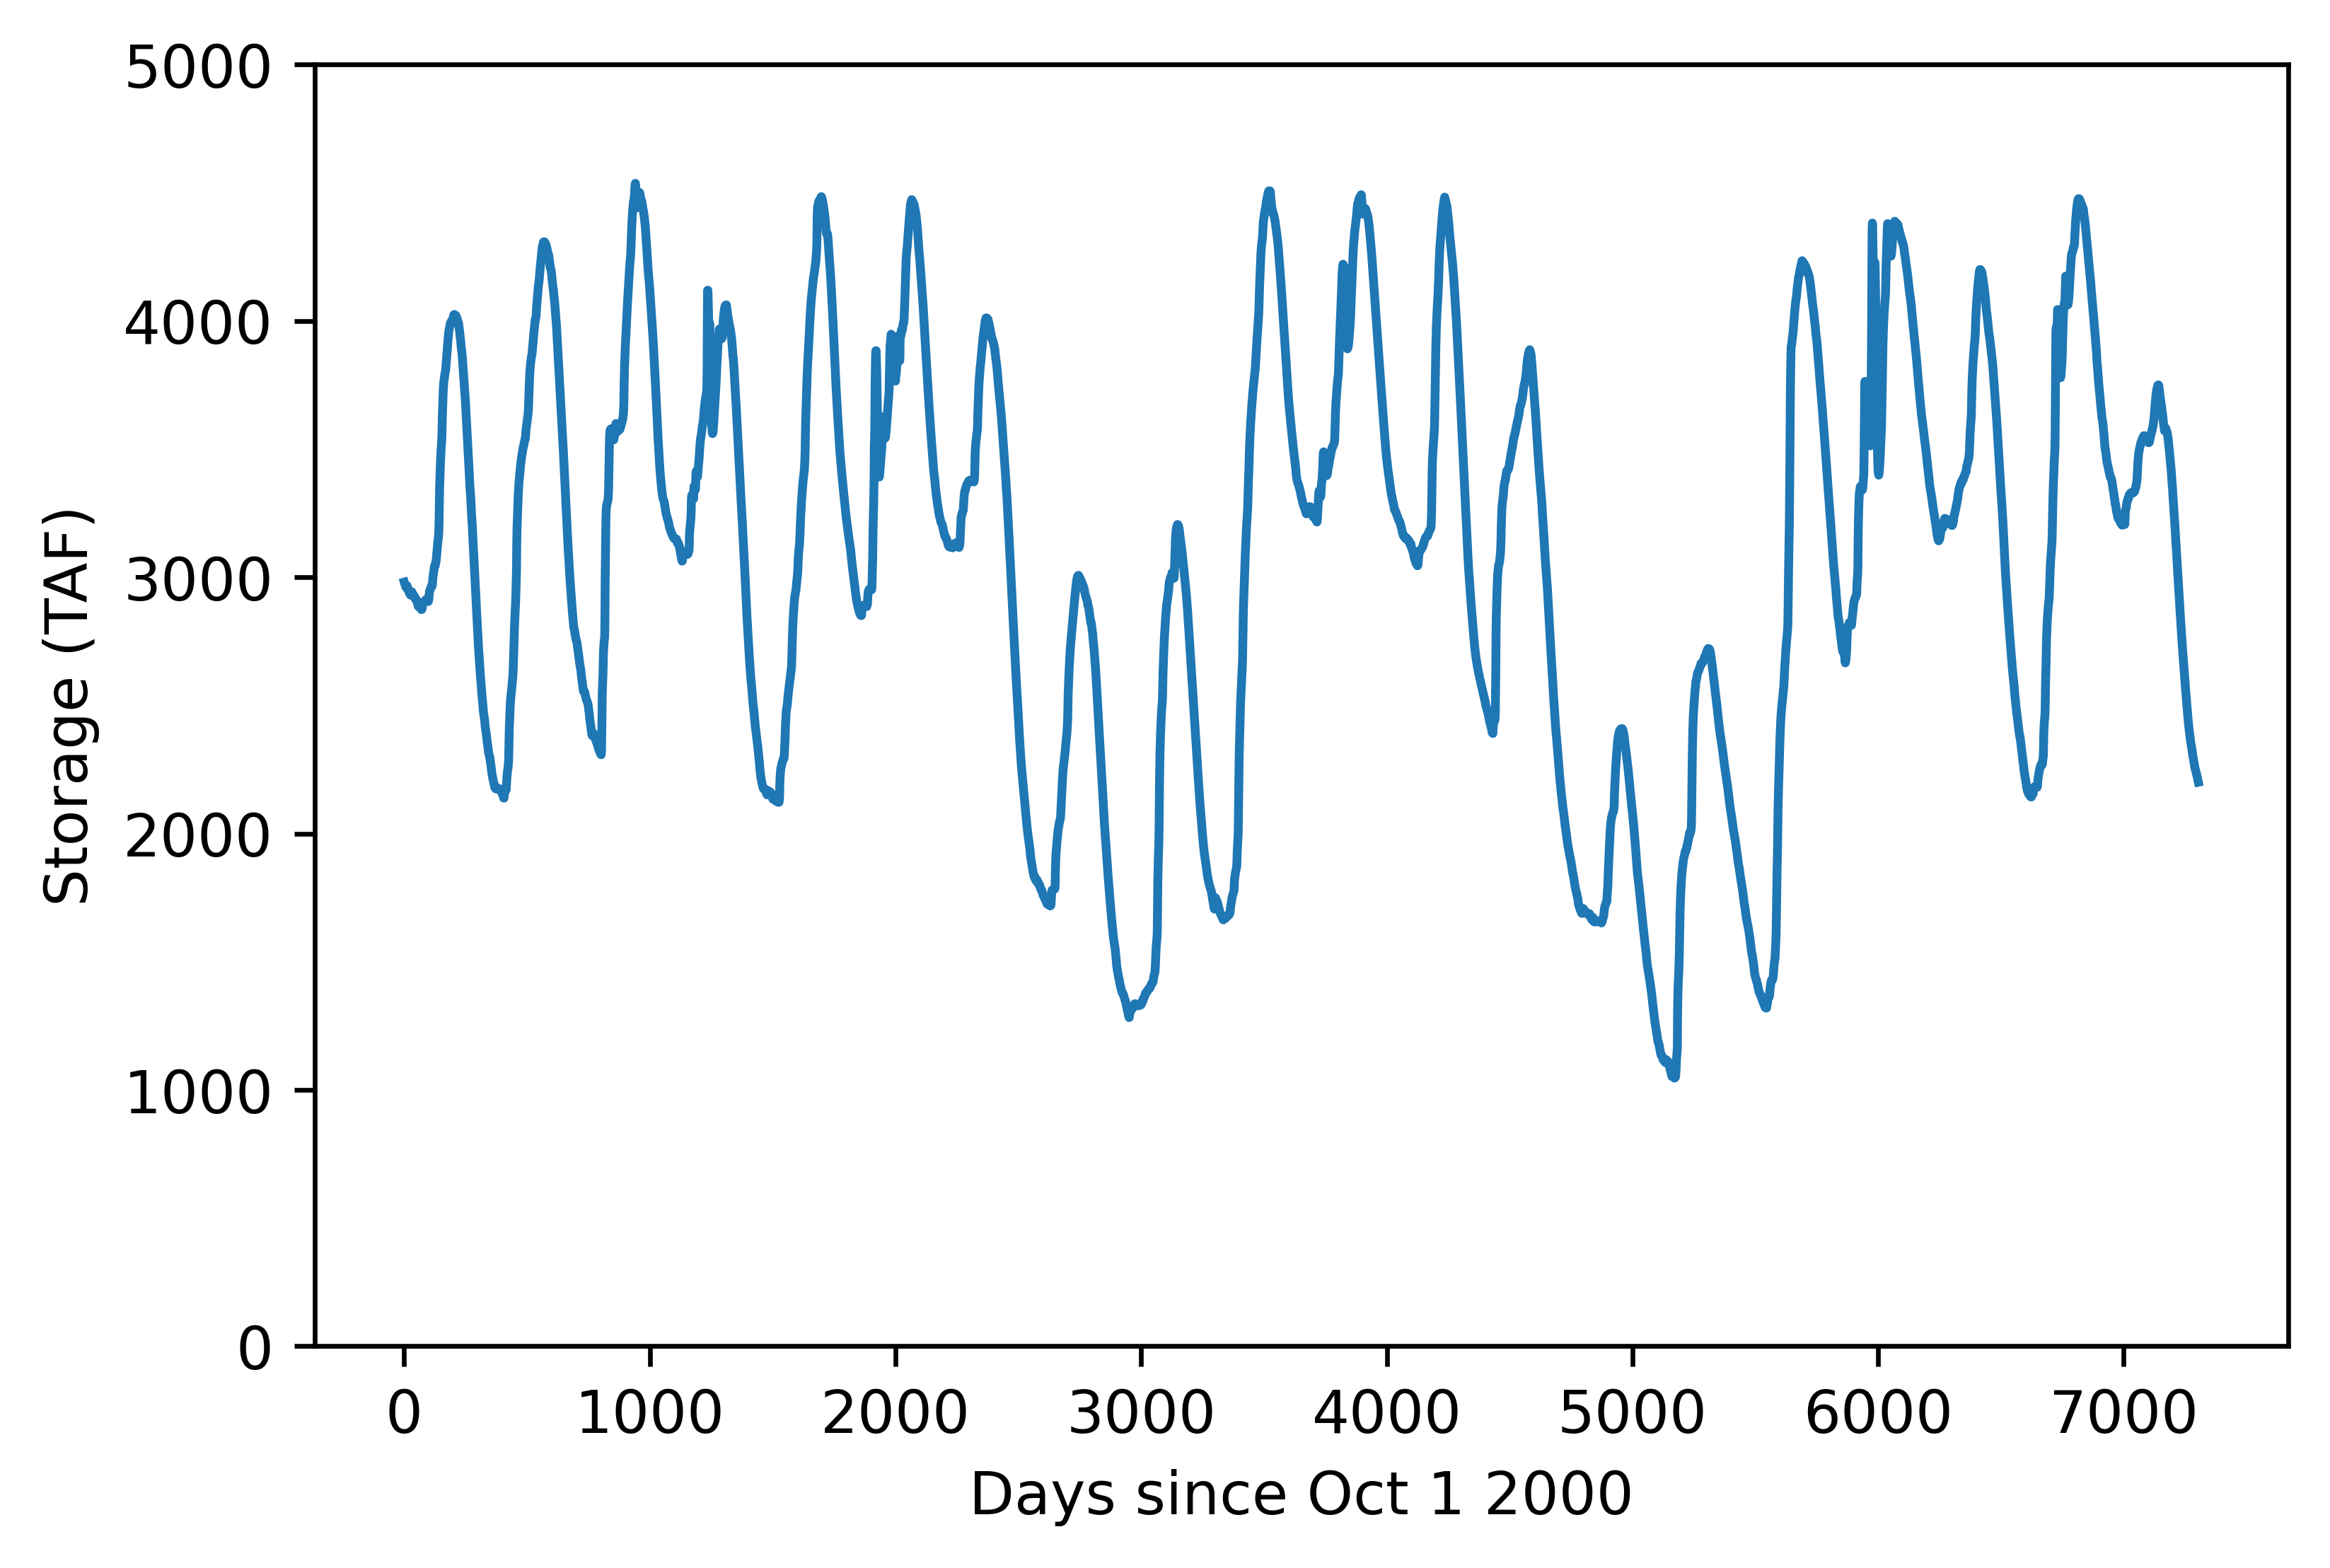

In [4]:
plt.plot(storage)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.ylim([0,5000])
plt.show()

#### Second plot: time series of inflow and outflow

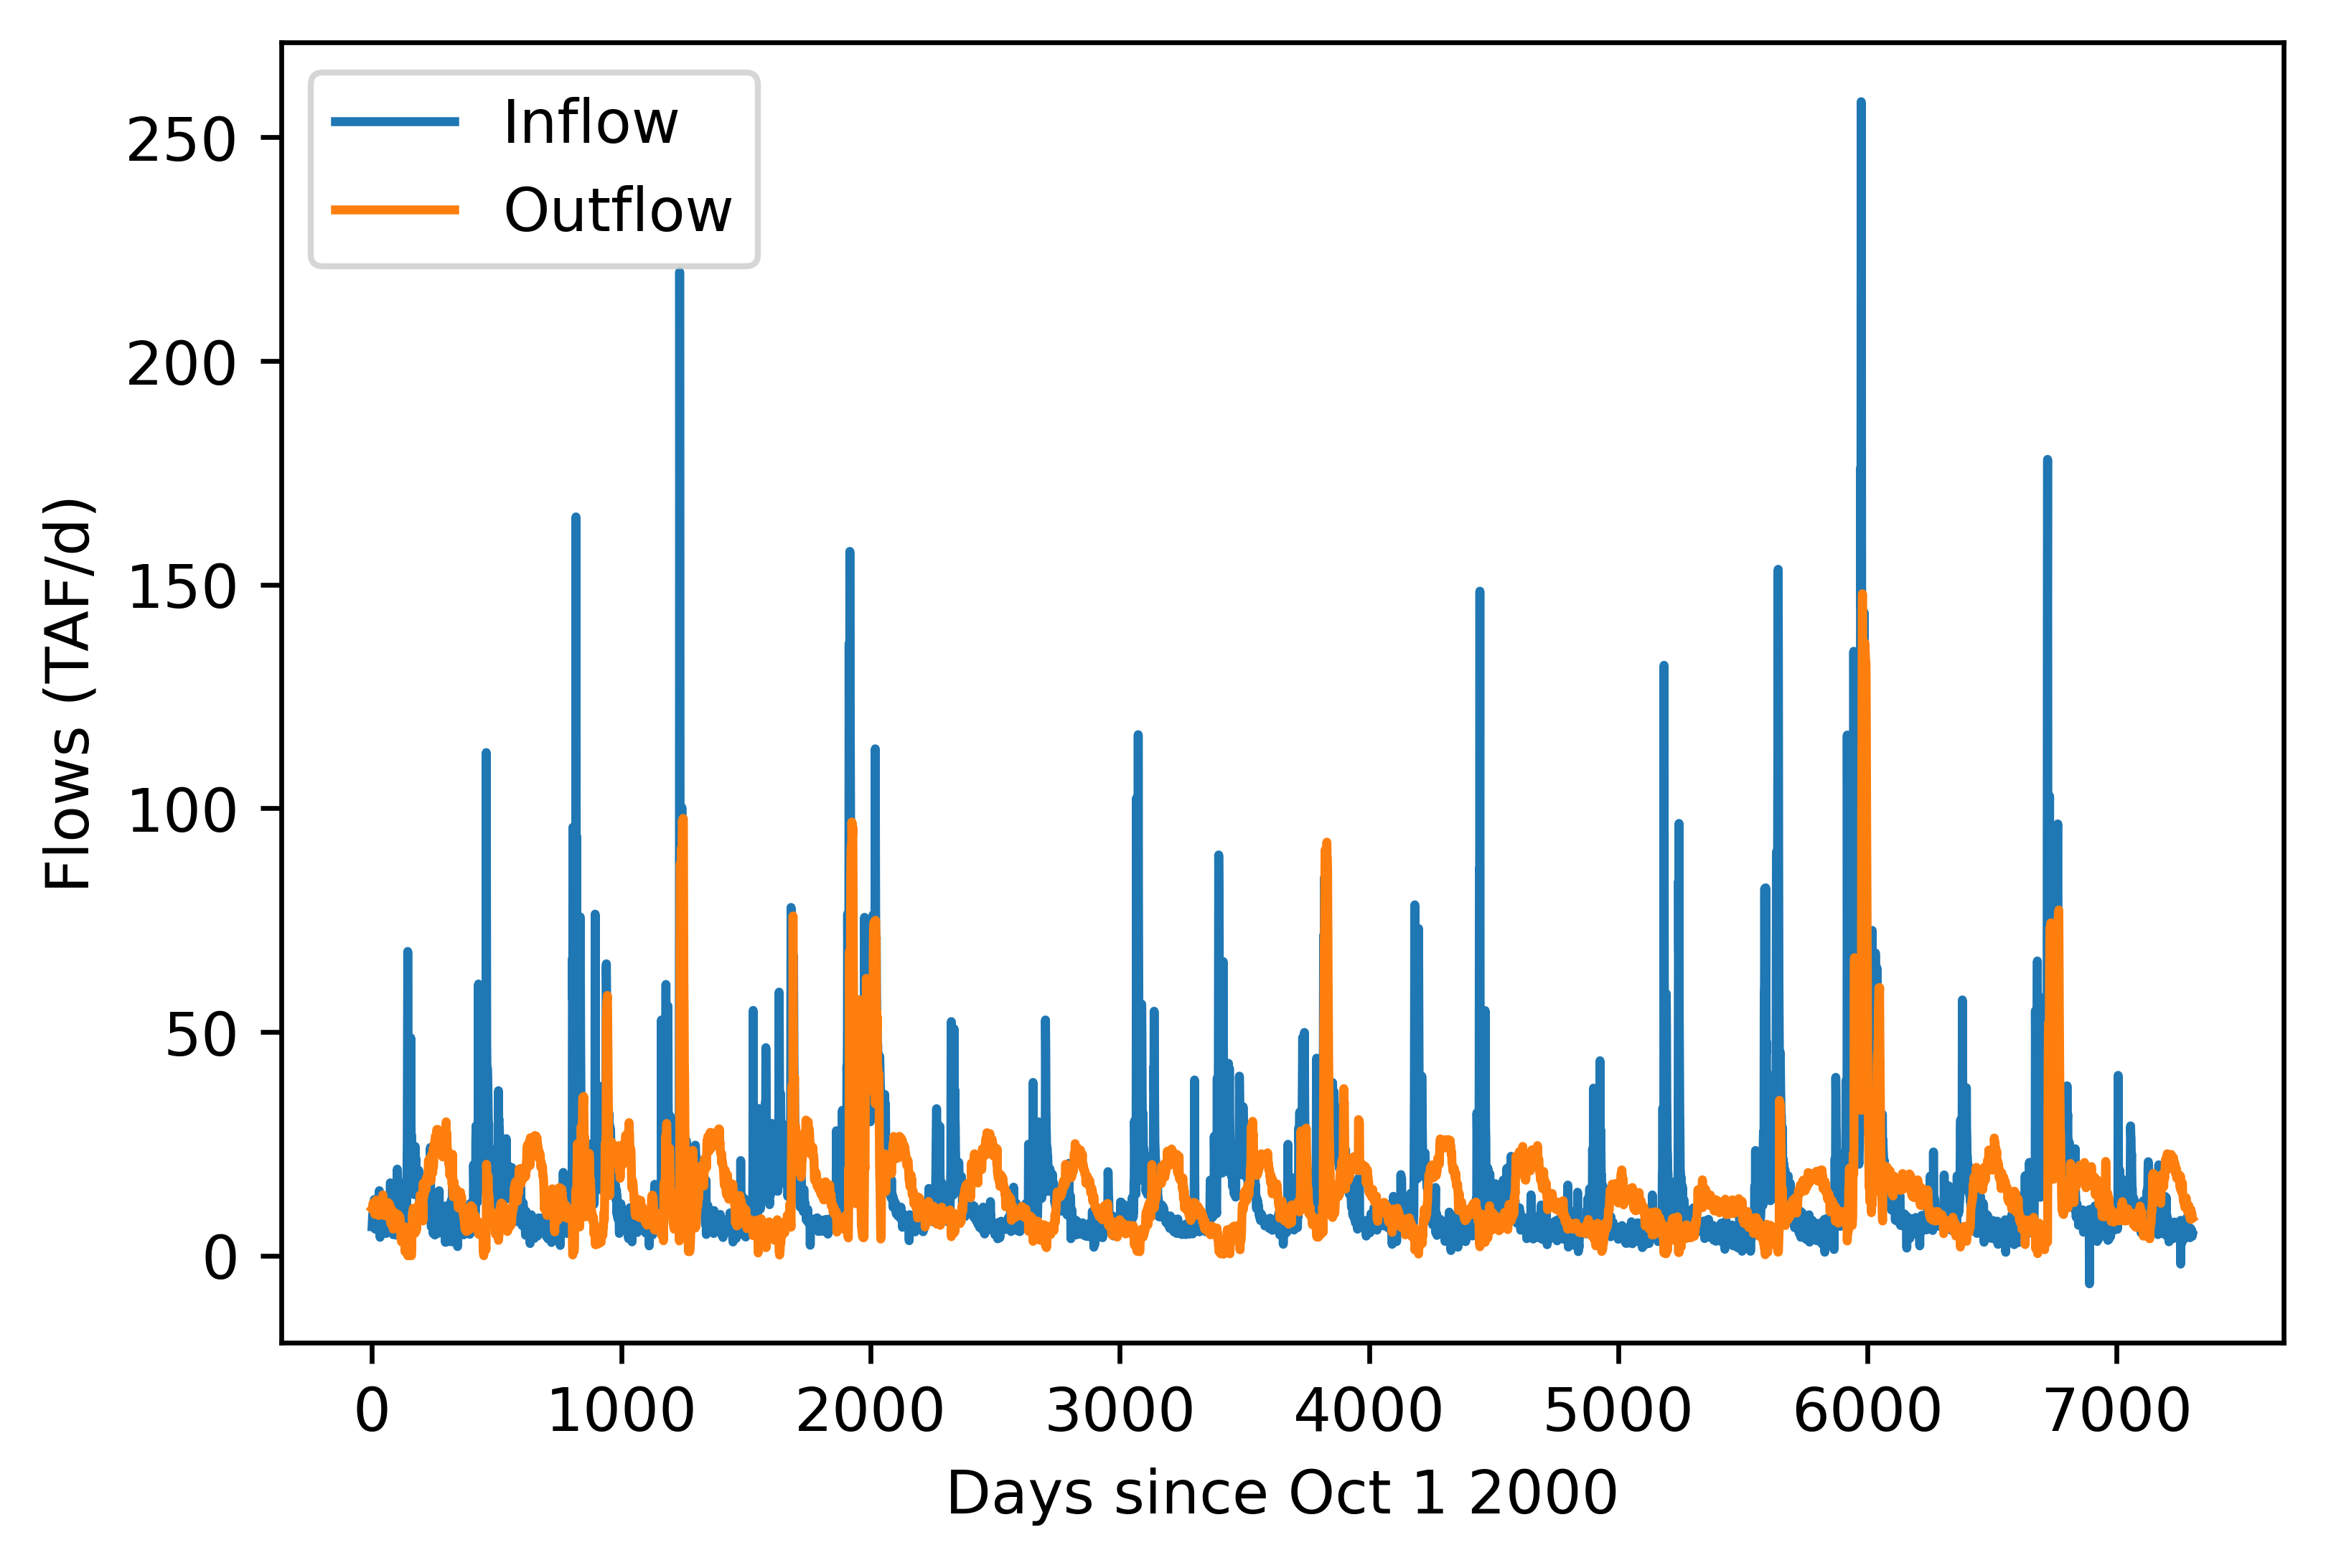

In [5]:
plt.plot(inflow)
plt.plot(outflow)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Flows (TAF/d)')
plt.legend(['Inflow', 'Outflow'])
plt.show()

#### Third plot: exceedance plot of inflow and outflow

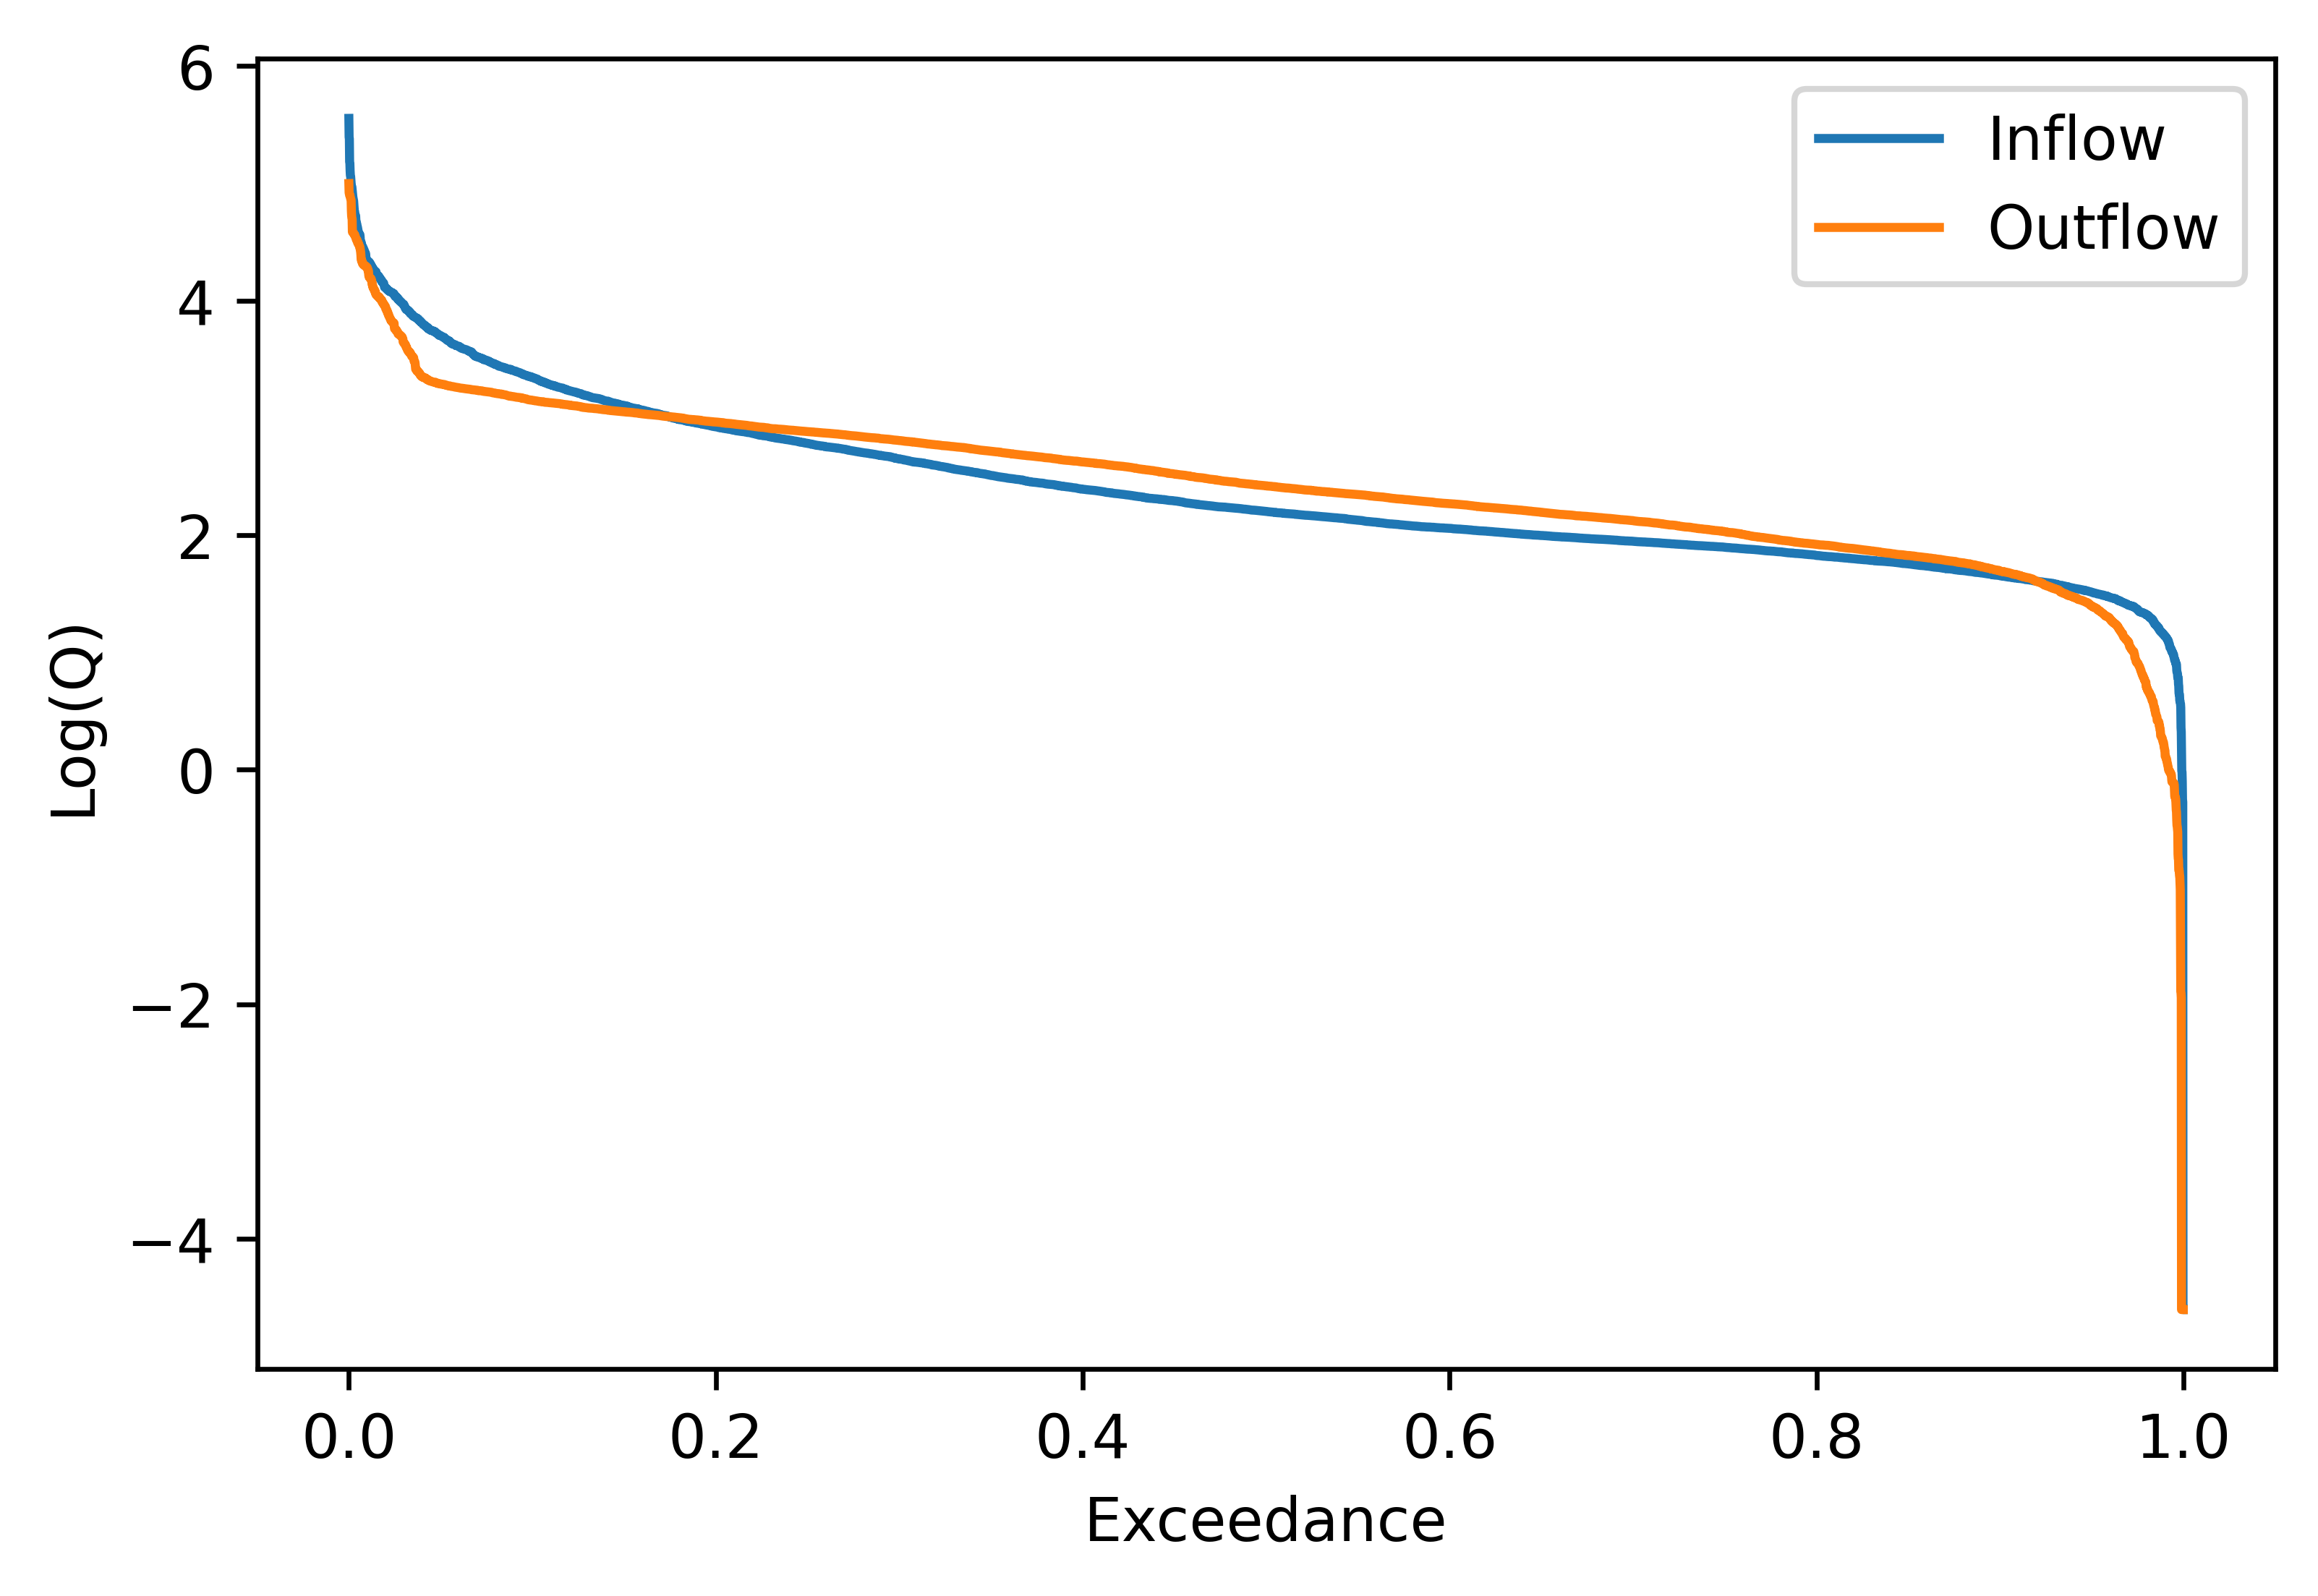

In [6]:
T = len(inflow)

# before log-transforming, replace ~zeros with small values to avoid warning
inflow[inflow < 0.01] = 0.01
outflow[outflow < 0.01] = 0.01
log_inflow = np.log(inflow)
log_outflow = np.log(outflow)

plt.plot(np.arange(T)/T, np.sort(log_inflow)[::-1])
plt.plot(np.arange(T)/T, np.sort(log_outflow)[::-1])
plt.legend(['Inflow', 'Outflow'])
plt.ylabel('Log(Q)')
plt.xlabel('Exceedance')
plt.show()

#### Fourth plot: historical storage for Folsom, Oroville, and Shasta

Plot on the same graph

In [7]:
reservoirs = ['FOL', 'ORO', 'SHA']

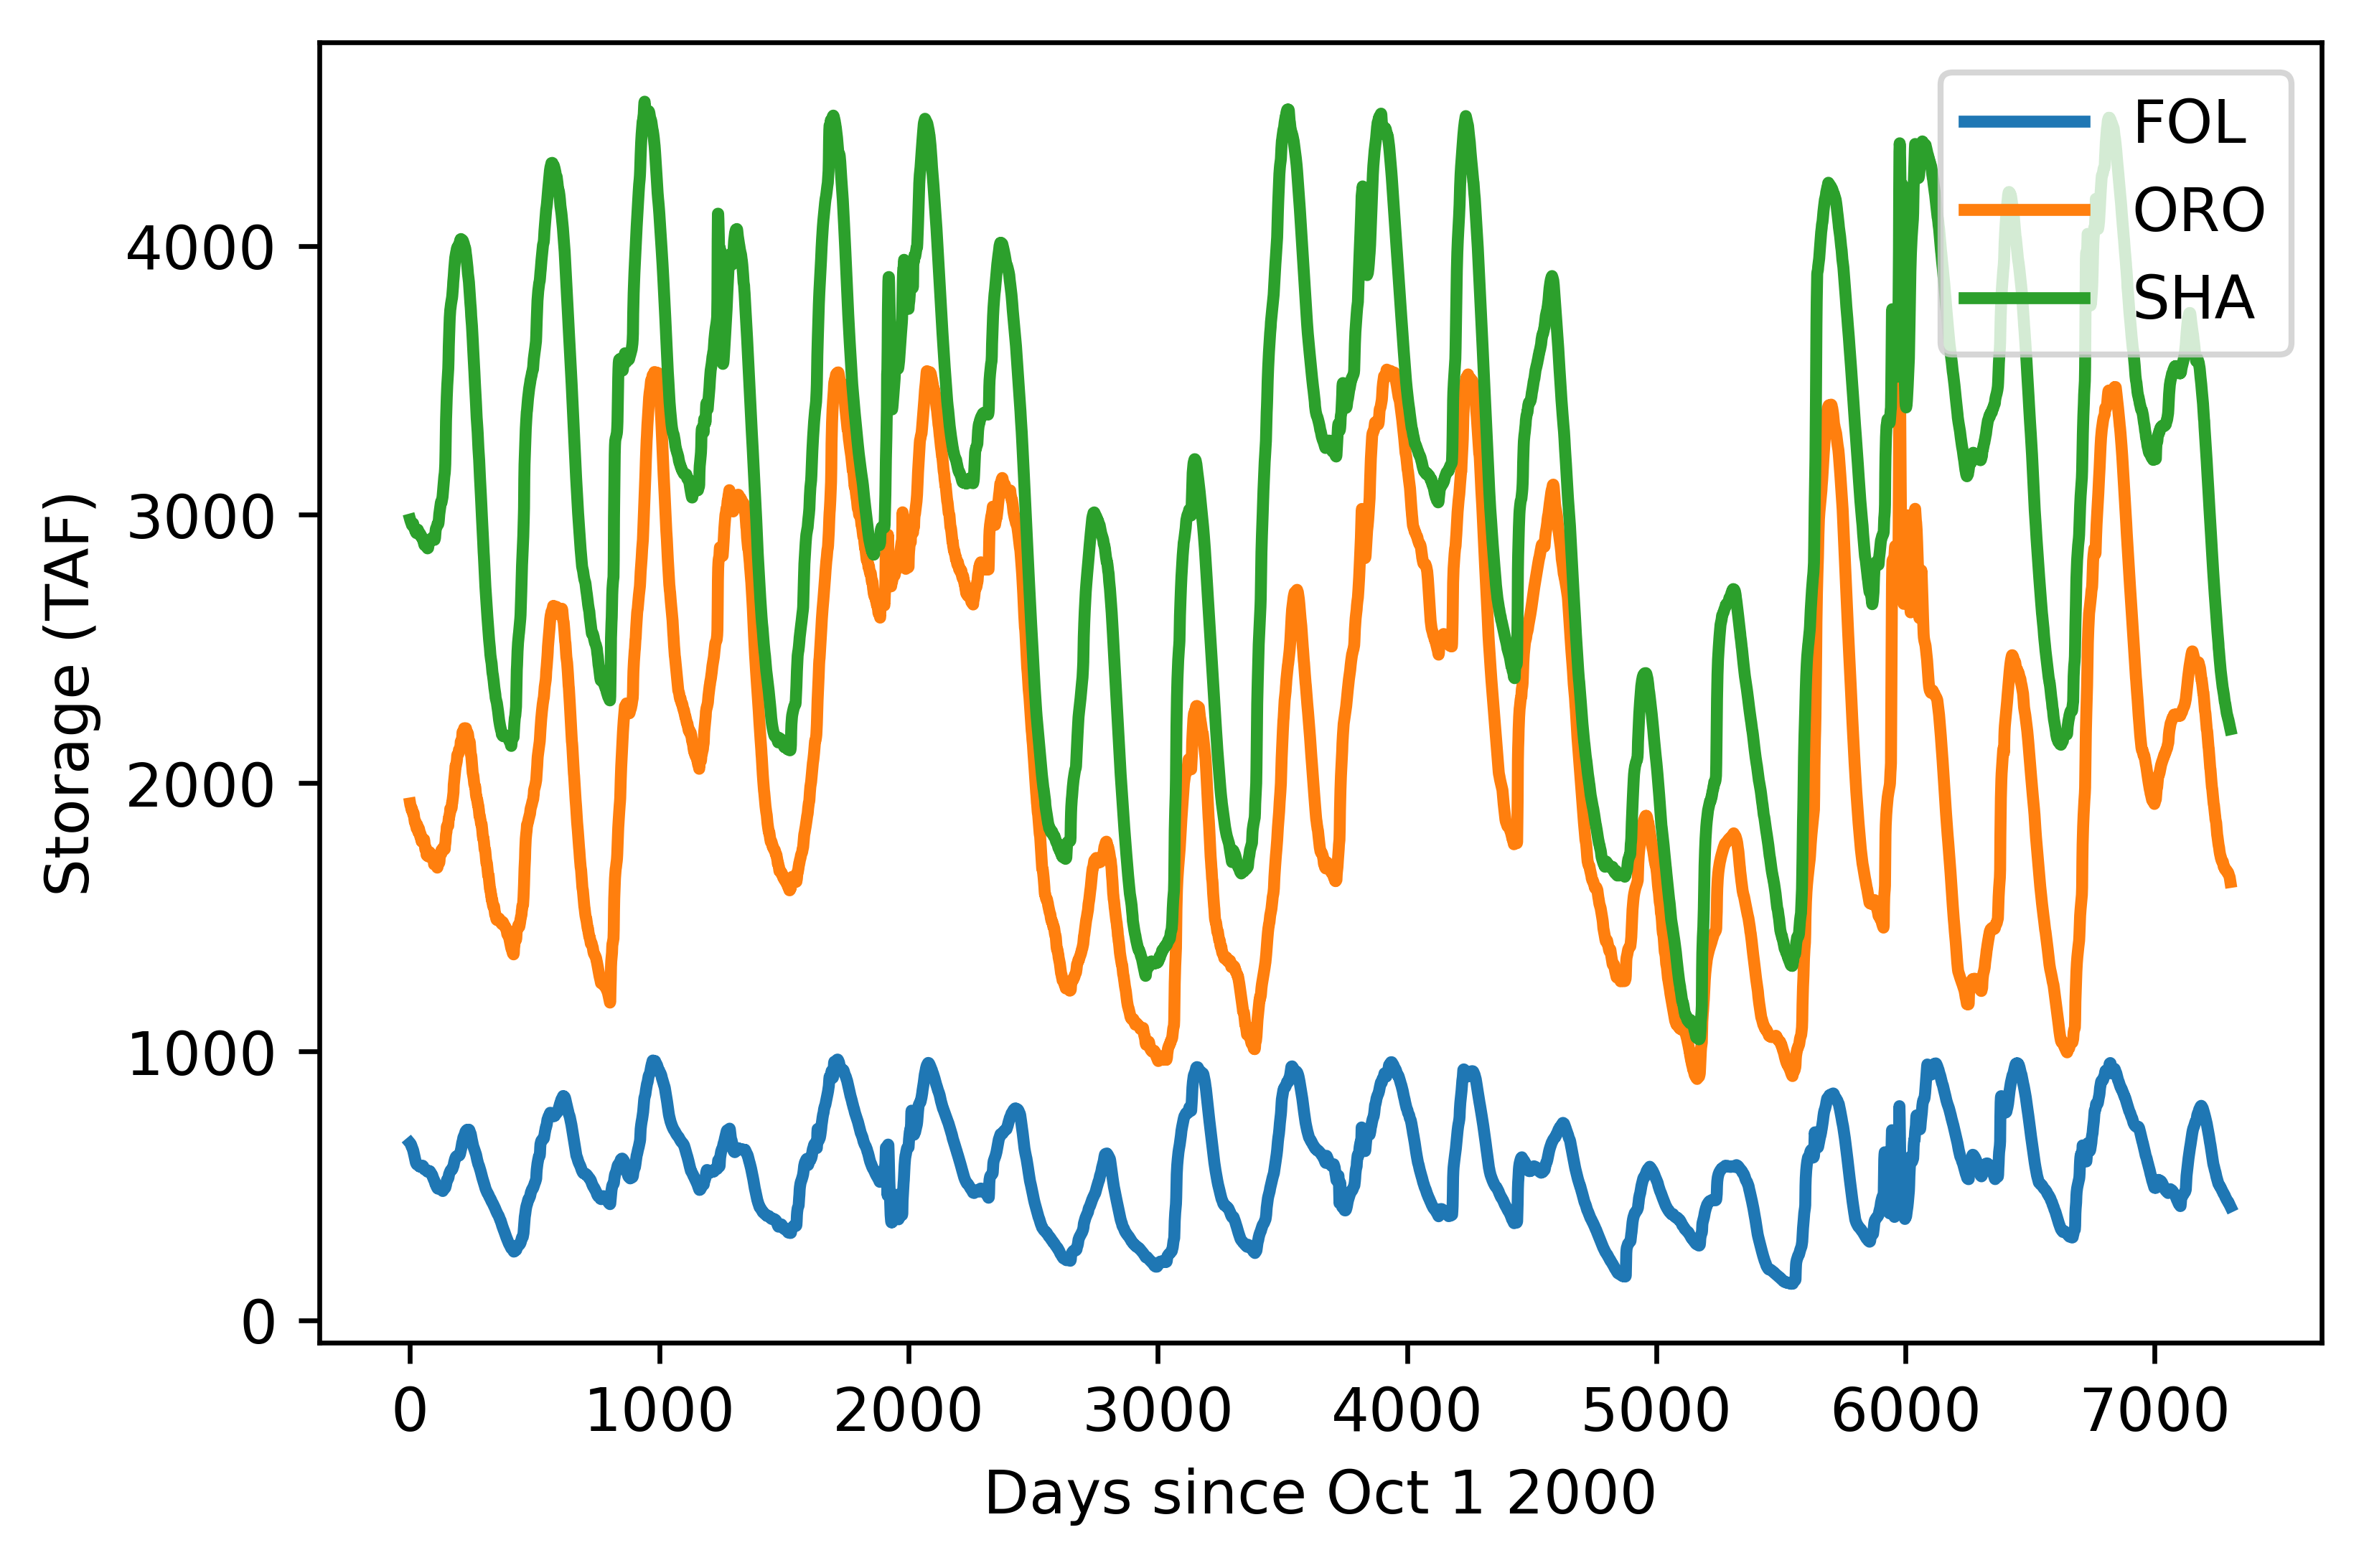

In [8]:
for r in reservoirs:
    data = np.loadtxt('data/' + r + '.csv', 
                    delimiter=',', 
                    skiprows=1, 
                    usecols=[1,2,3])
    
    storage = data[:,2] / 1000 # AF to TAF
    plt.plot(storage, linewidth=2)

plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.legend(reservoirs)

# optional - save to file
# plt.savefig('something.png') # or .pdf, .svg, etc.
plt.show()

-------------------

## Simulation model

Mass balance reservoir simulation with constant demand and standard operating policy.

In [9]:
K = 975 # capacity, TAF
D = 5 # target demand, TAF/day

Data setup:

In [10]:
Q = np.loadtxt('data/FOL.csv', delimiter=',', 
                skiprows=1, usecols=[1])
Q *= cfs_to_tafd
T = len(Q)

S = np.zeros(T)
R = np.zeros(T)
shortage = np.zeros(T)

S[0] = K/2 # start simulation full
R[0] = D # first day meets demand
met_demand = 1 # counter

In [11]:
for t in range(1,T):

  # new storage: mass balance, max value is K
  S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

  # release is based on demand
  if S[t] + Q[t] > D:
    R[t] = D
    met_demand = met_demand + 1
  else:
    R[t] = S[t] + Q[t]

  shortage[t] = D-R[t]

reliability = met_demand / T
print('The reliability is', reliability)

The reliability is 0.9065023956194388


Plot storage, inflow, outflow, and shortage as subplots

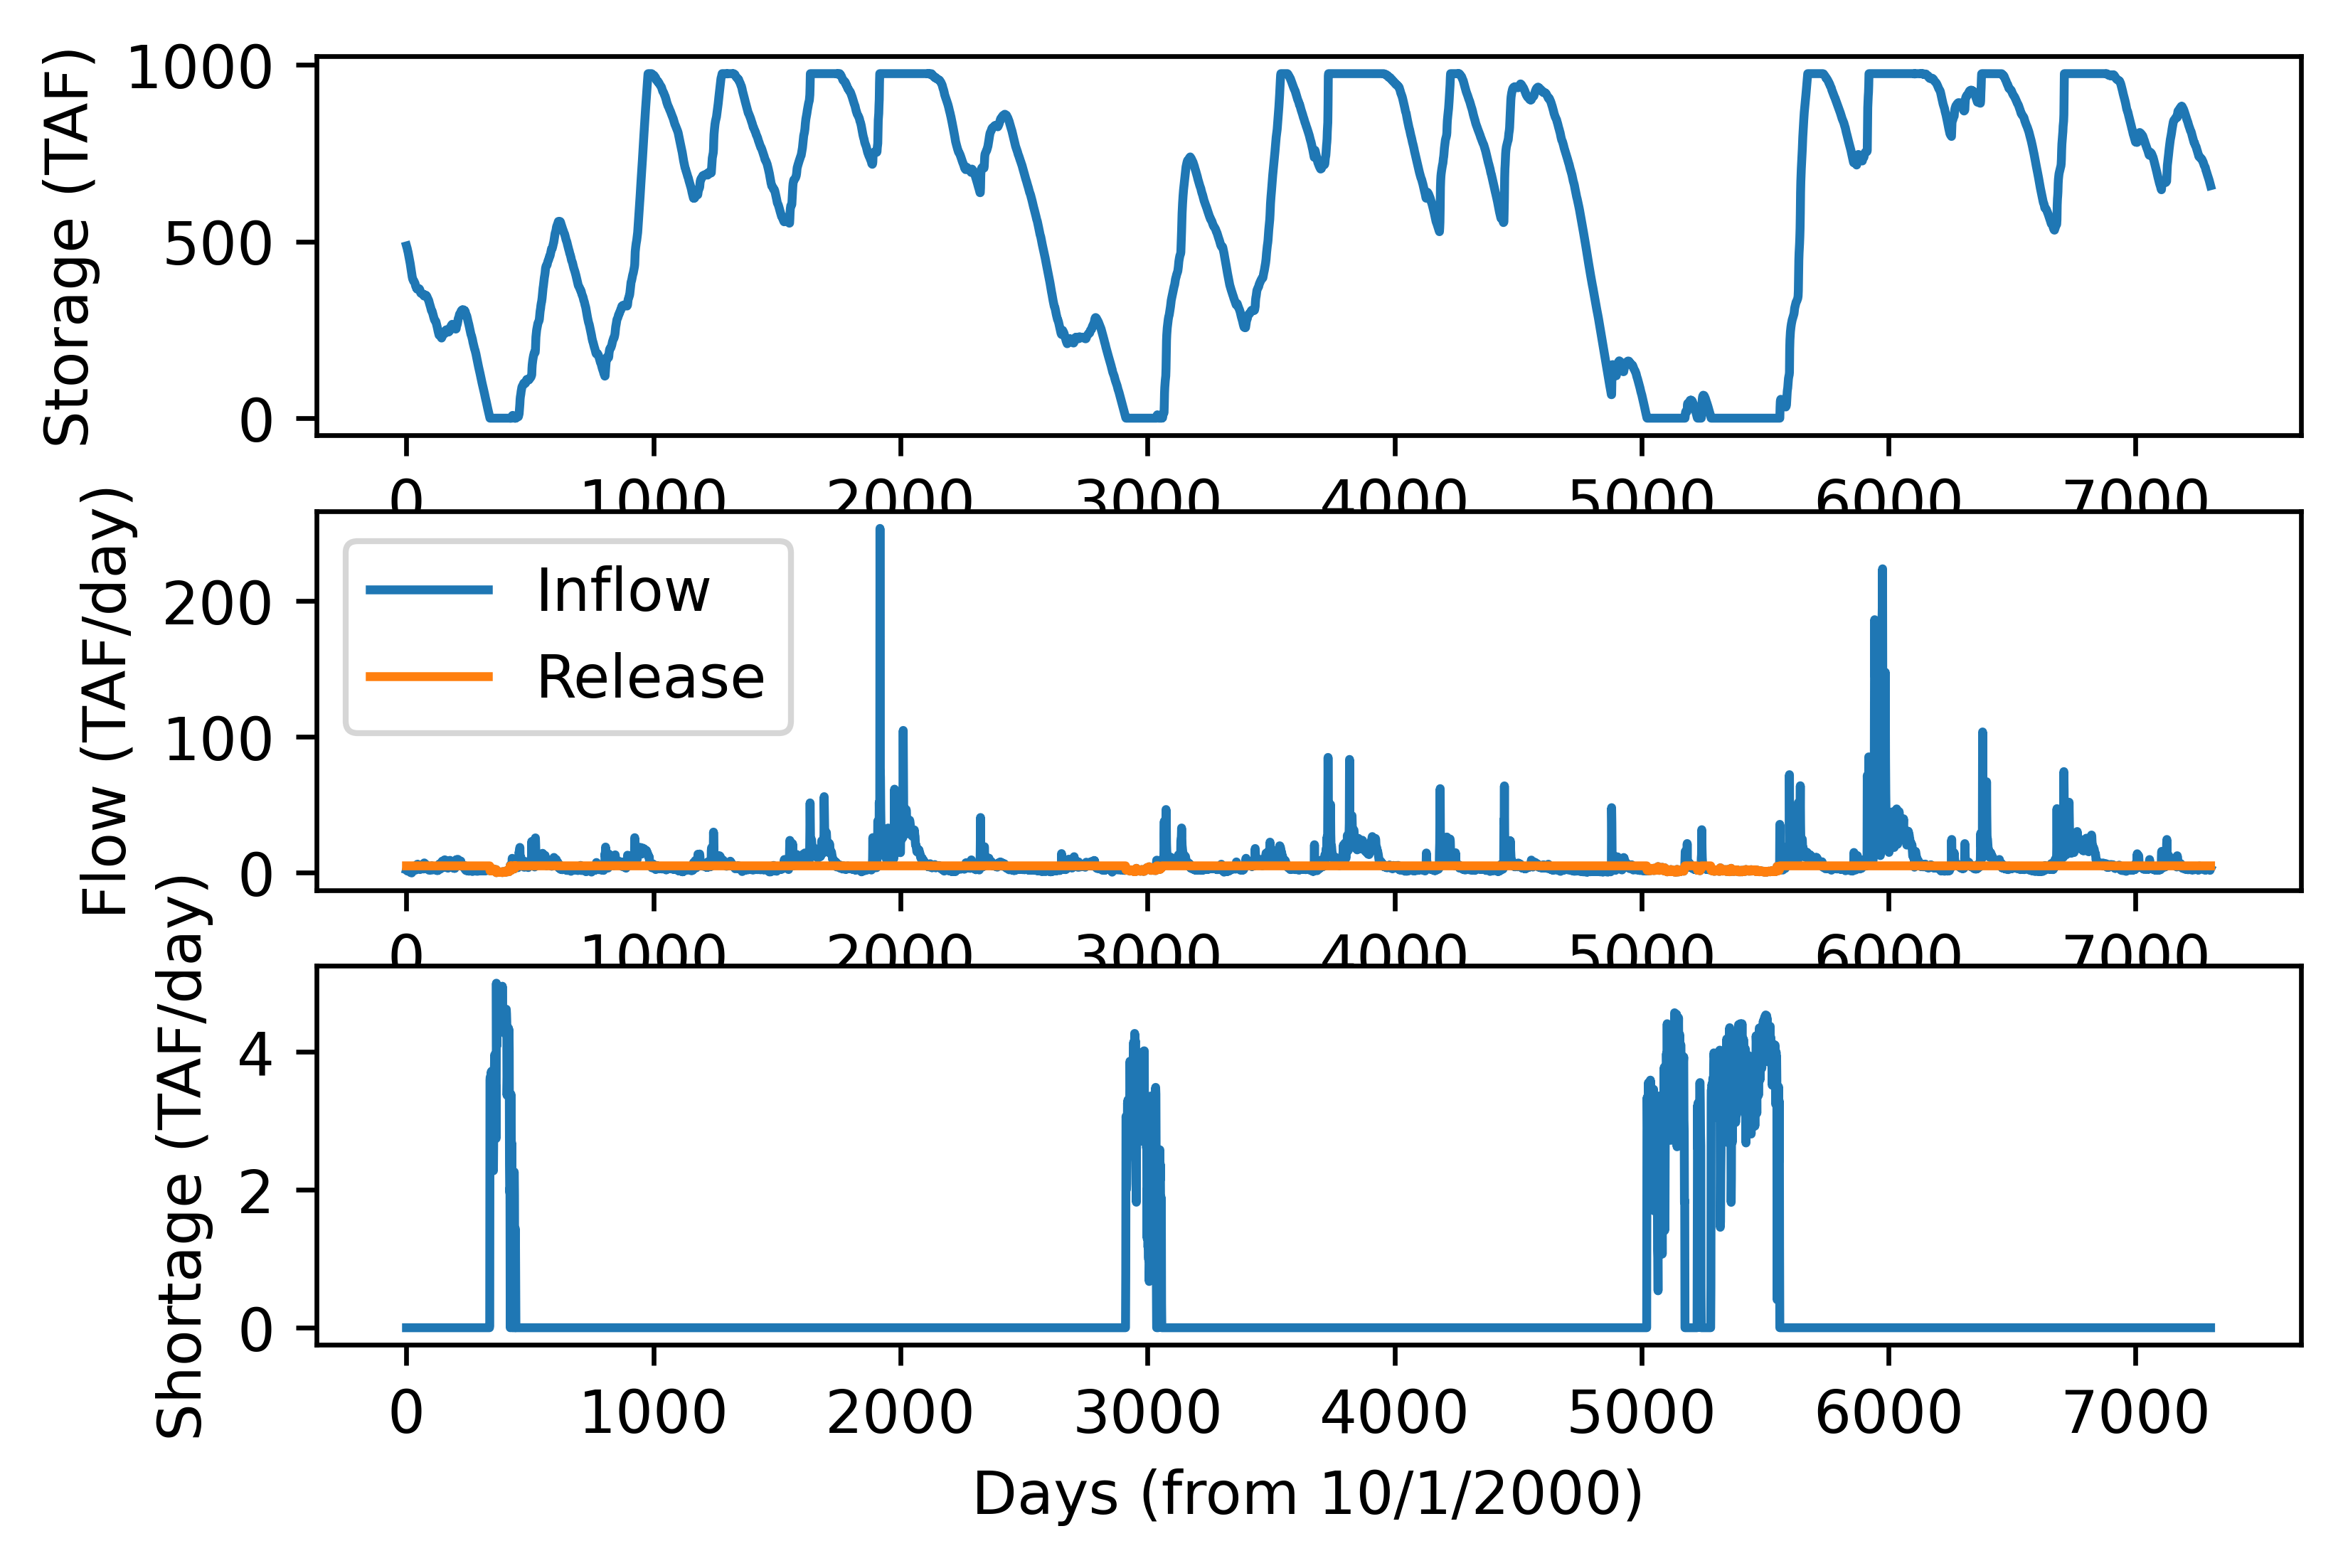

In [12]:
plt.subplot(3,1,1)
plt.plot(S)
plt.ylabel('Storage (TAF)')

plt.subplot(3,1,2)
plt.plot(Q)
plt.plot(R)
plt.legend(['Inflow', 'Release'])
plt.ylabel('Flow (TAF/day)')

plt.subplot(3,1,3)
plt.plot(shortage)
plt.ylabel('Shortage (TAF/day)')
plt.xlabel('Days (from 10/1/2000)')

plt.show()

------------

Extensions: using the `ulmo` package to download CDEC data

Installation instructions: https://github.com/ulmo-dev/ulmo

CDEC API: https://ulmo.readthedocs.io/en/latest/api.html#module-ulmo.cdec.historical


In [13]:
from ulmo import cdec

# find all sensors for a station
cdec.historical.get_station_sensors(['FOL'])

ModuleNotFoundError: No module named 'ulmo'

In [14]:
# download - returns a dictionary of pandas DataFrame objects
data = cdec.historical.get_data(['FOL'], resolutions=['daily'], start='10-01-2000', end='09-30-2021')

NameError: name 'cdec' is not defined

In [15]:
print(data)

[[3.262000e+03 5.255000e+03 2.980848e+06]
 [3.793000e+03 5.283000e+03 2.977473e+06]
 [4.437000e+03 5.246000e+03 2.975448e+06]
 ...
 [2.836000e+03 4.704000e+03 2.208796e+06]
 [2.182000e+03 4.259000e+03 2.204399e+06]
 [2.317000e+03 4.217000e+03 2.200375e+06]]


The URLs may be broken using this library. Instead we can use our own scraper (located in this directory):

In [16]:
from cdec_scraper import cdec_sensor_data

df = cdec_sensor_data('FOL', 15, 'M', sd='1953-10-01', ed='2022-06-30')
print(df)

            FOL_STORAGE_AF
datetime                  
1955-10-01          160262
1955-11-01          172633
1955-12-01          520807
1956-01-01          477361
1956-02-01          495074
...                    ...
2022-02-01          525949
2022-03-01          584055
2022-04-01          768402
2022-05-01          864790
2022-06-01          806973

[801 rows x 1 columns]


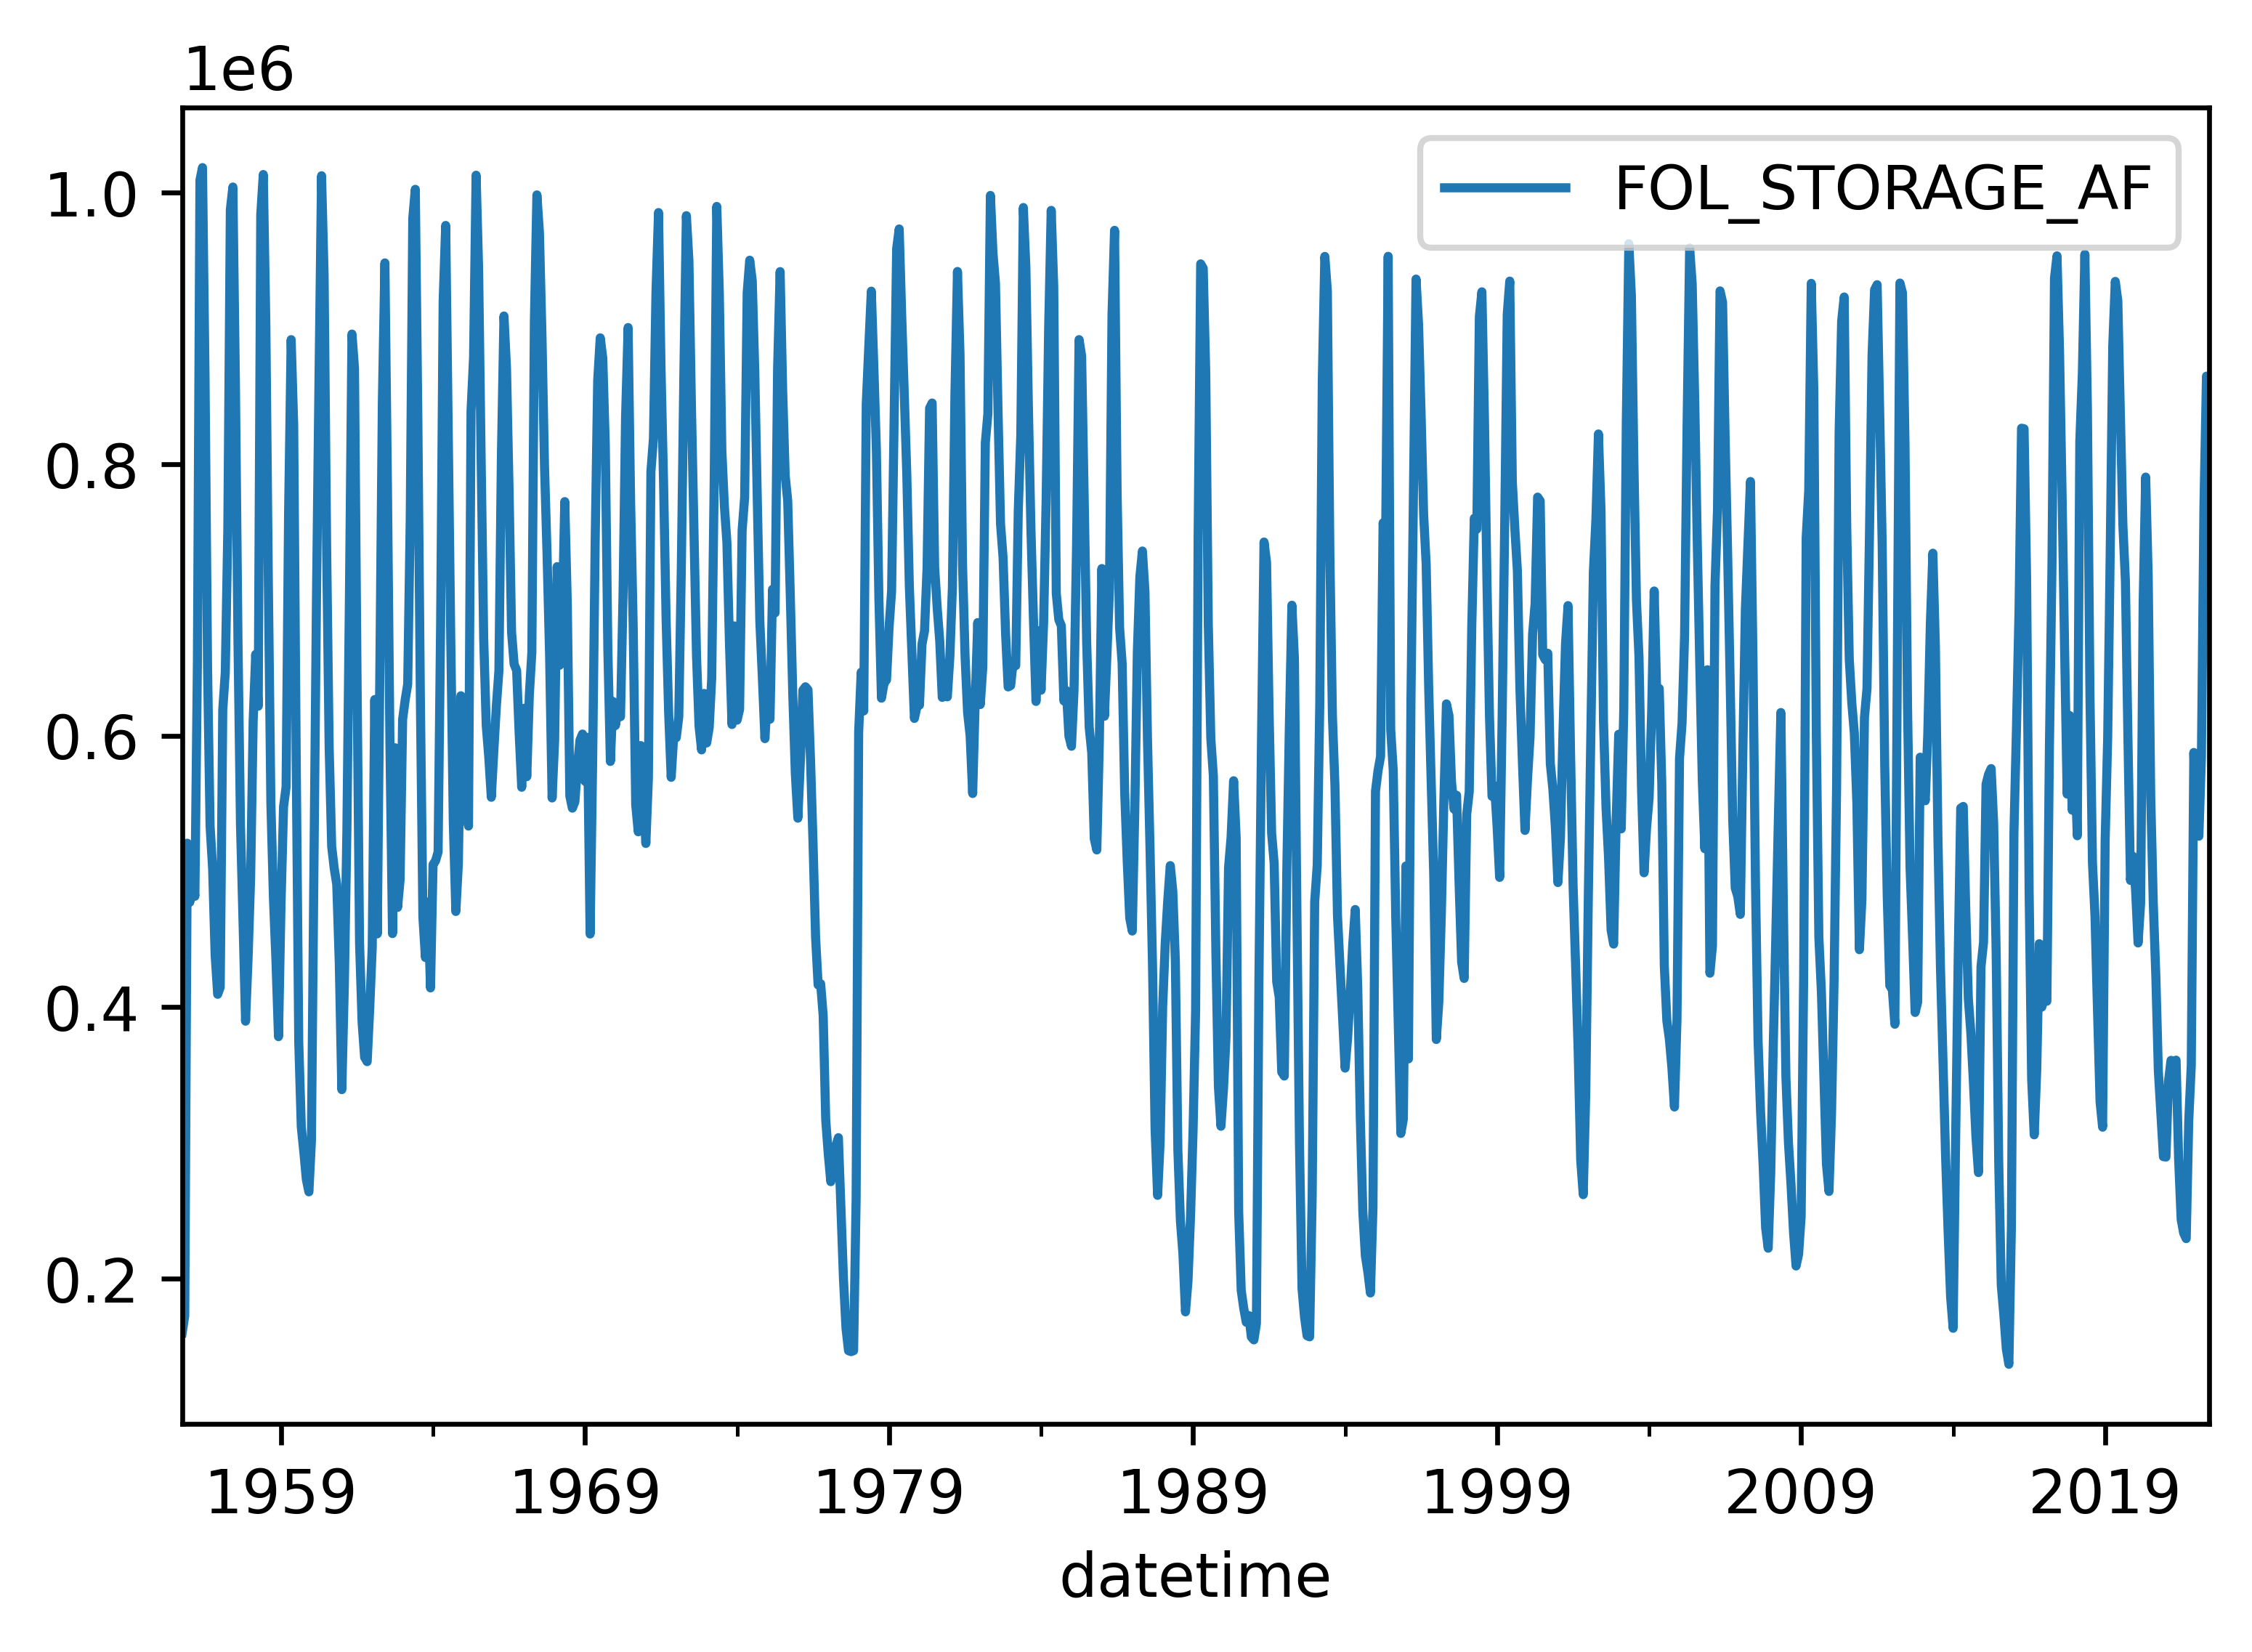

In [17]:
df.plot()
plt.show()

The data is returned in a pandas dataframe. You can also convert it to a numpy array:

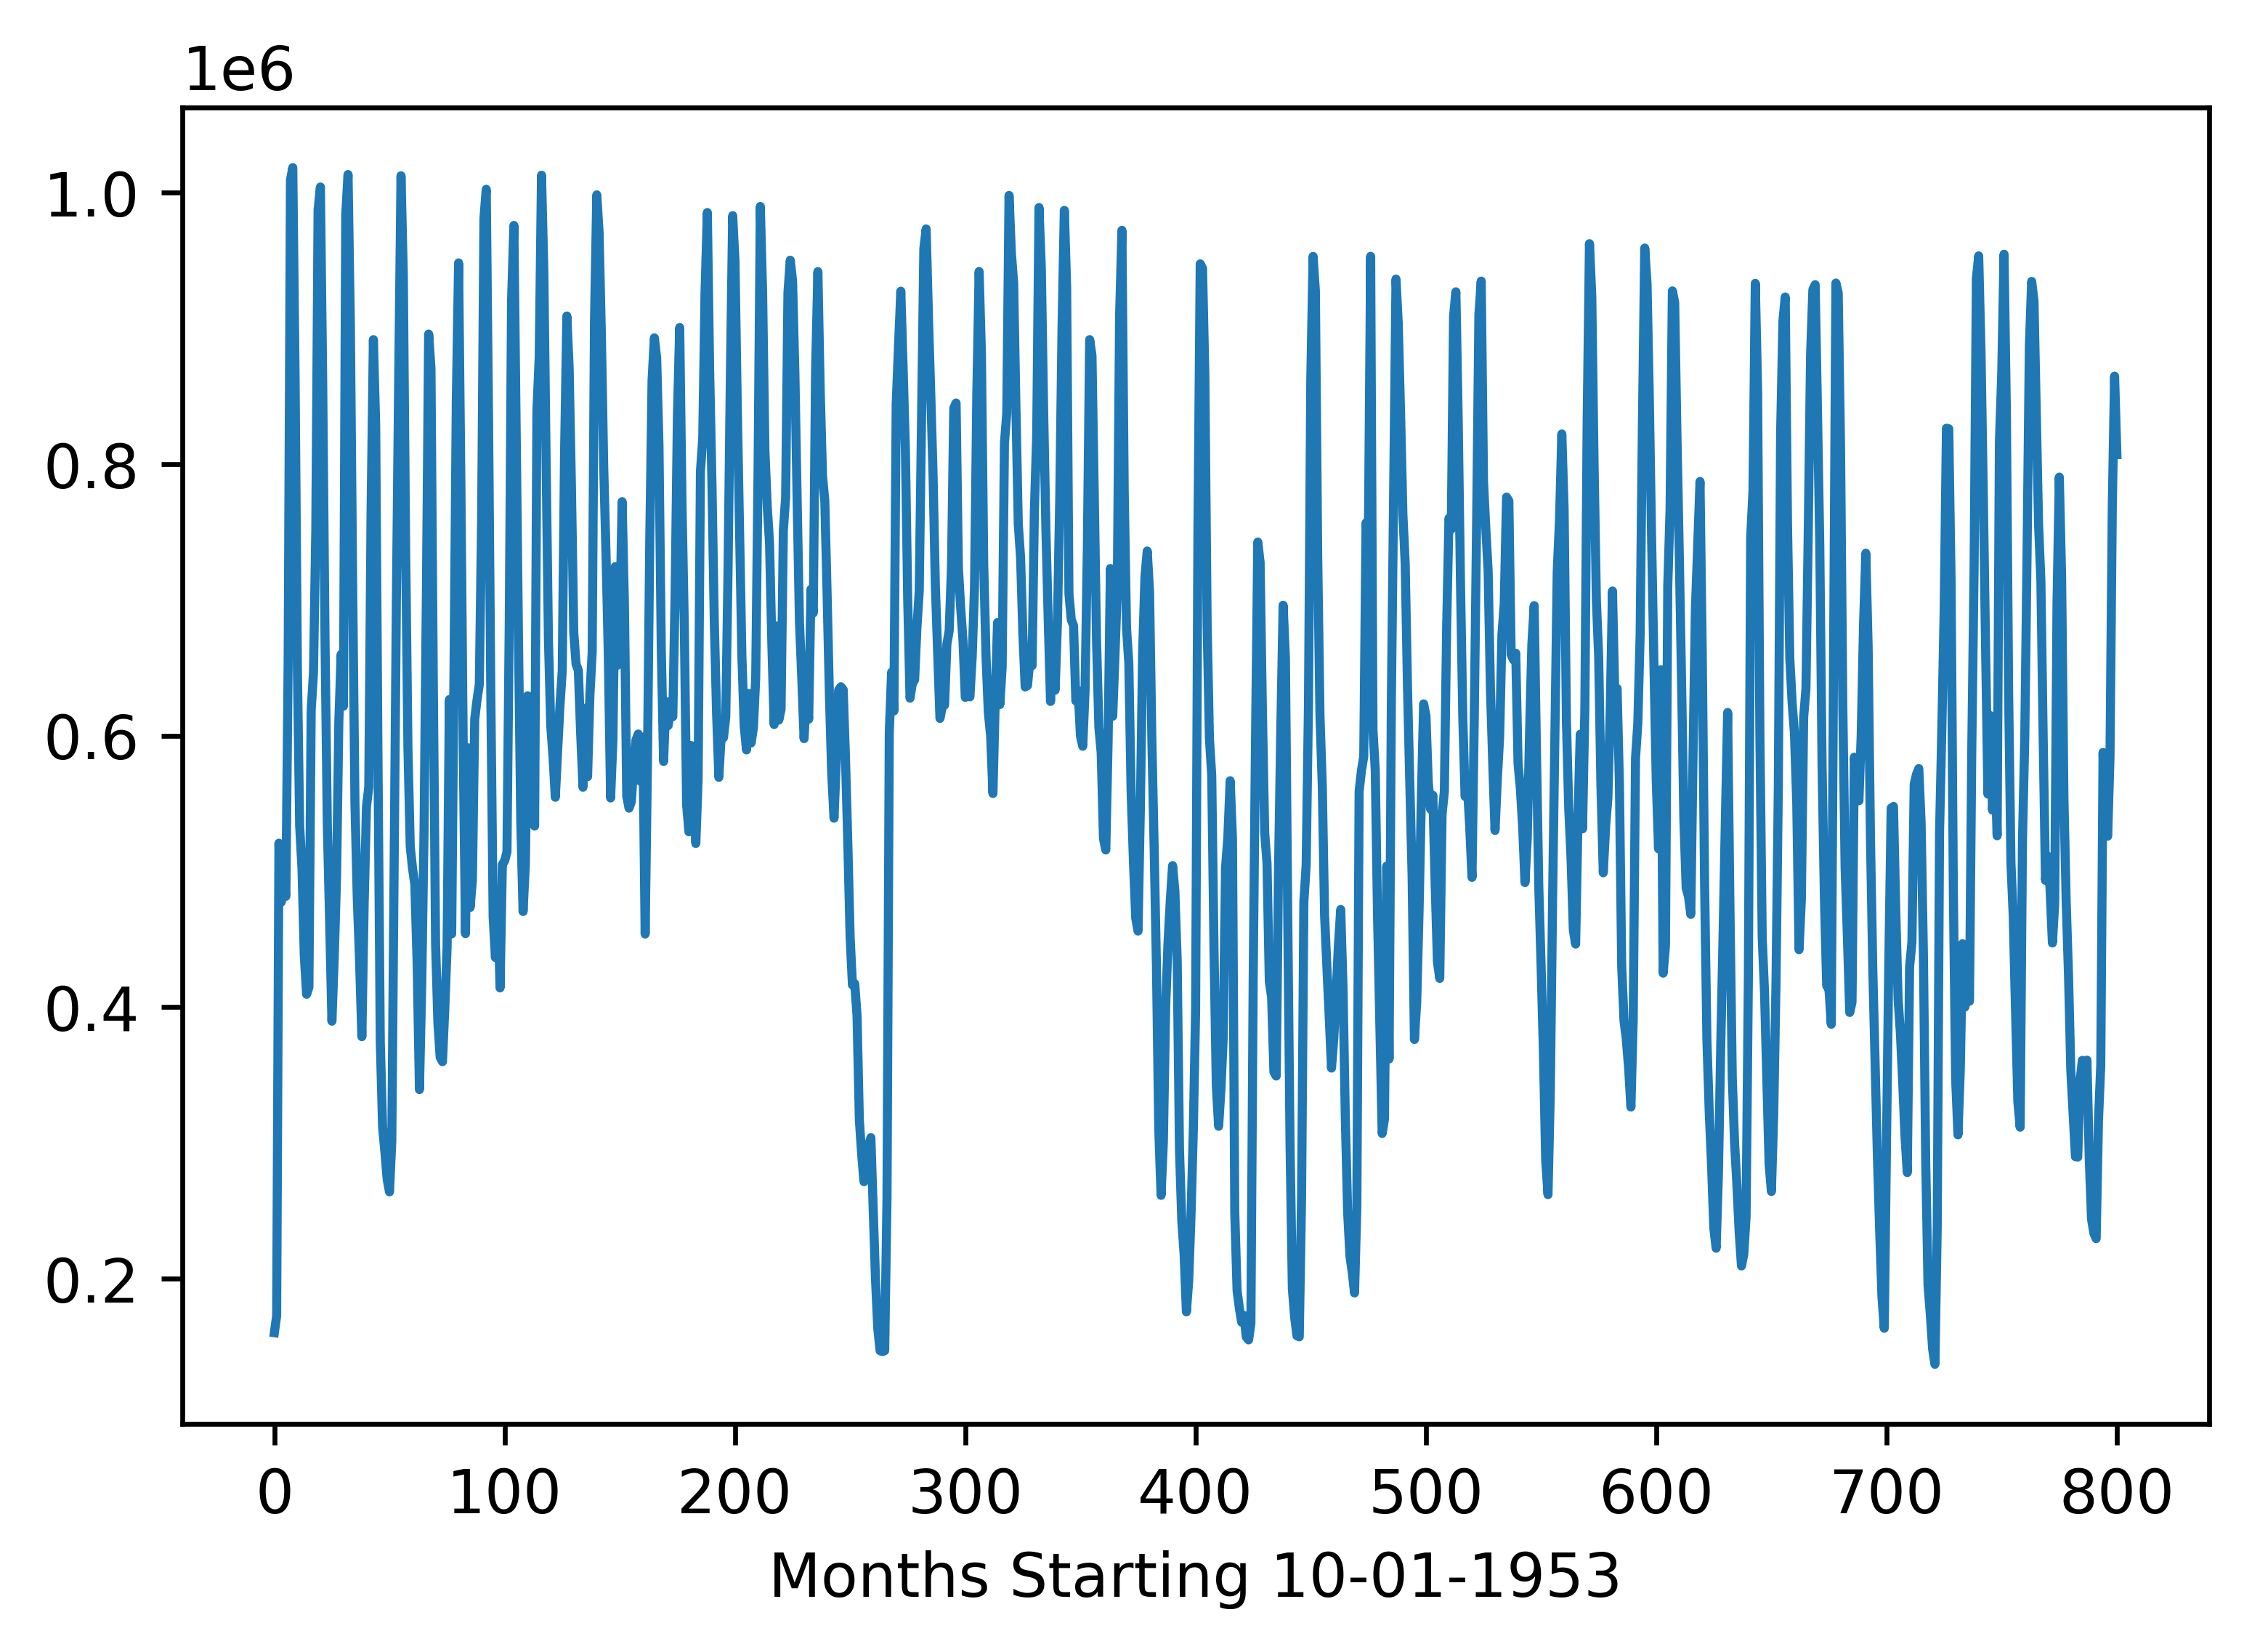

In [18]:
SHA_storage = df.values

plt.plot(SHA_storage)
plt.xlabel('Months Starting 10-01-1953')
plt.show()